This document calculates the trajectory for a spacecraft called the Universal Space Platform to the asteroid Themis

11.895 km / s


c:\users\disser\appdata\local\programs\python\python39\lib\site-packages\erfa\core.py:154: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

c:\users\disser\appdata\local\programs\python\python39\lib\site-packages\erfa\core.py:154: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\users\disser\appdata\local\programs\python\python39\lib\site-packages\erfa\core.py:154: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



([<matplotlib.collections.LineCollection at 0x2bb37ea8850>],
 <matplotlib.lines.Line2D at 0x2bb39ad95e0>)

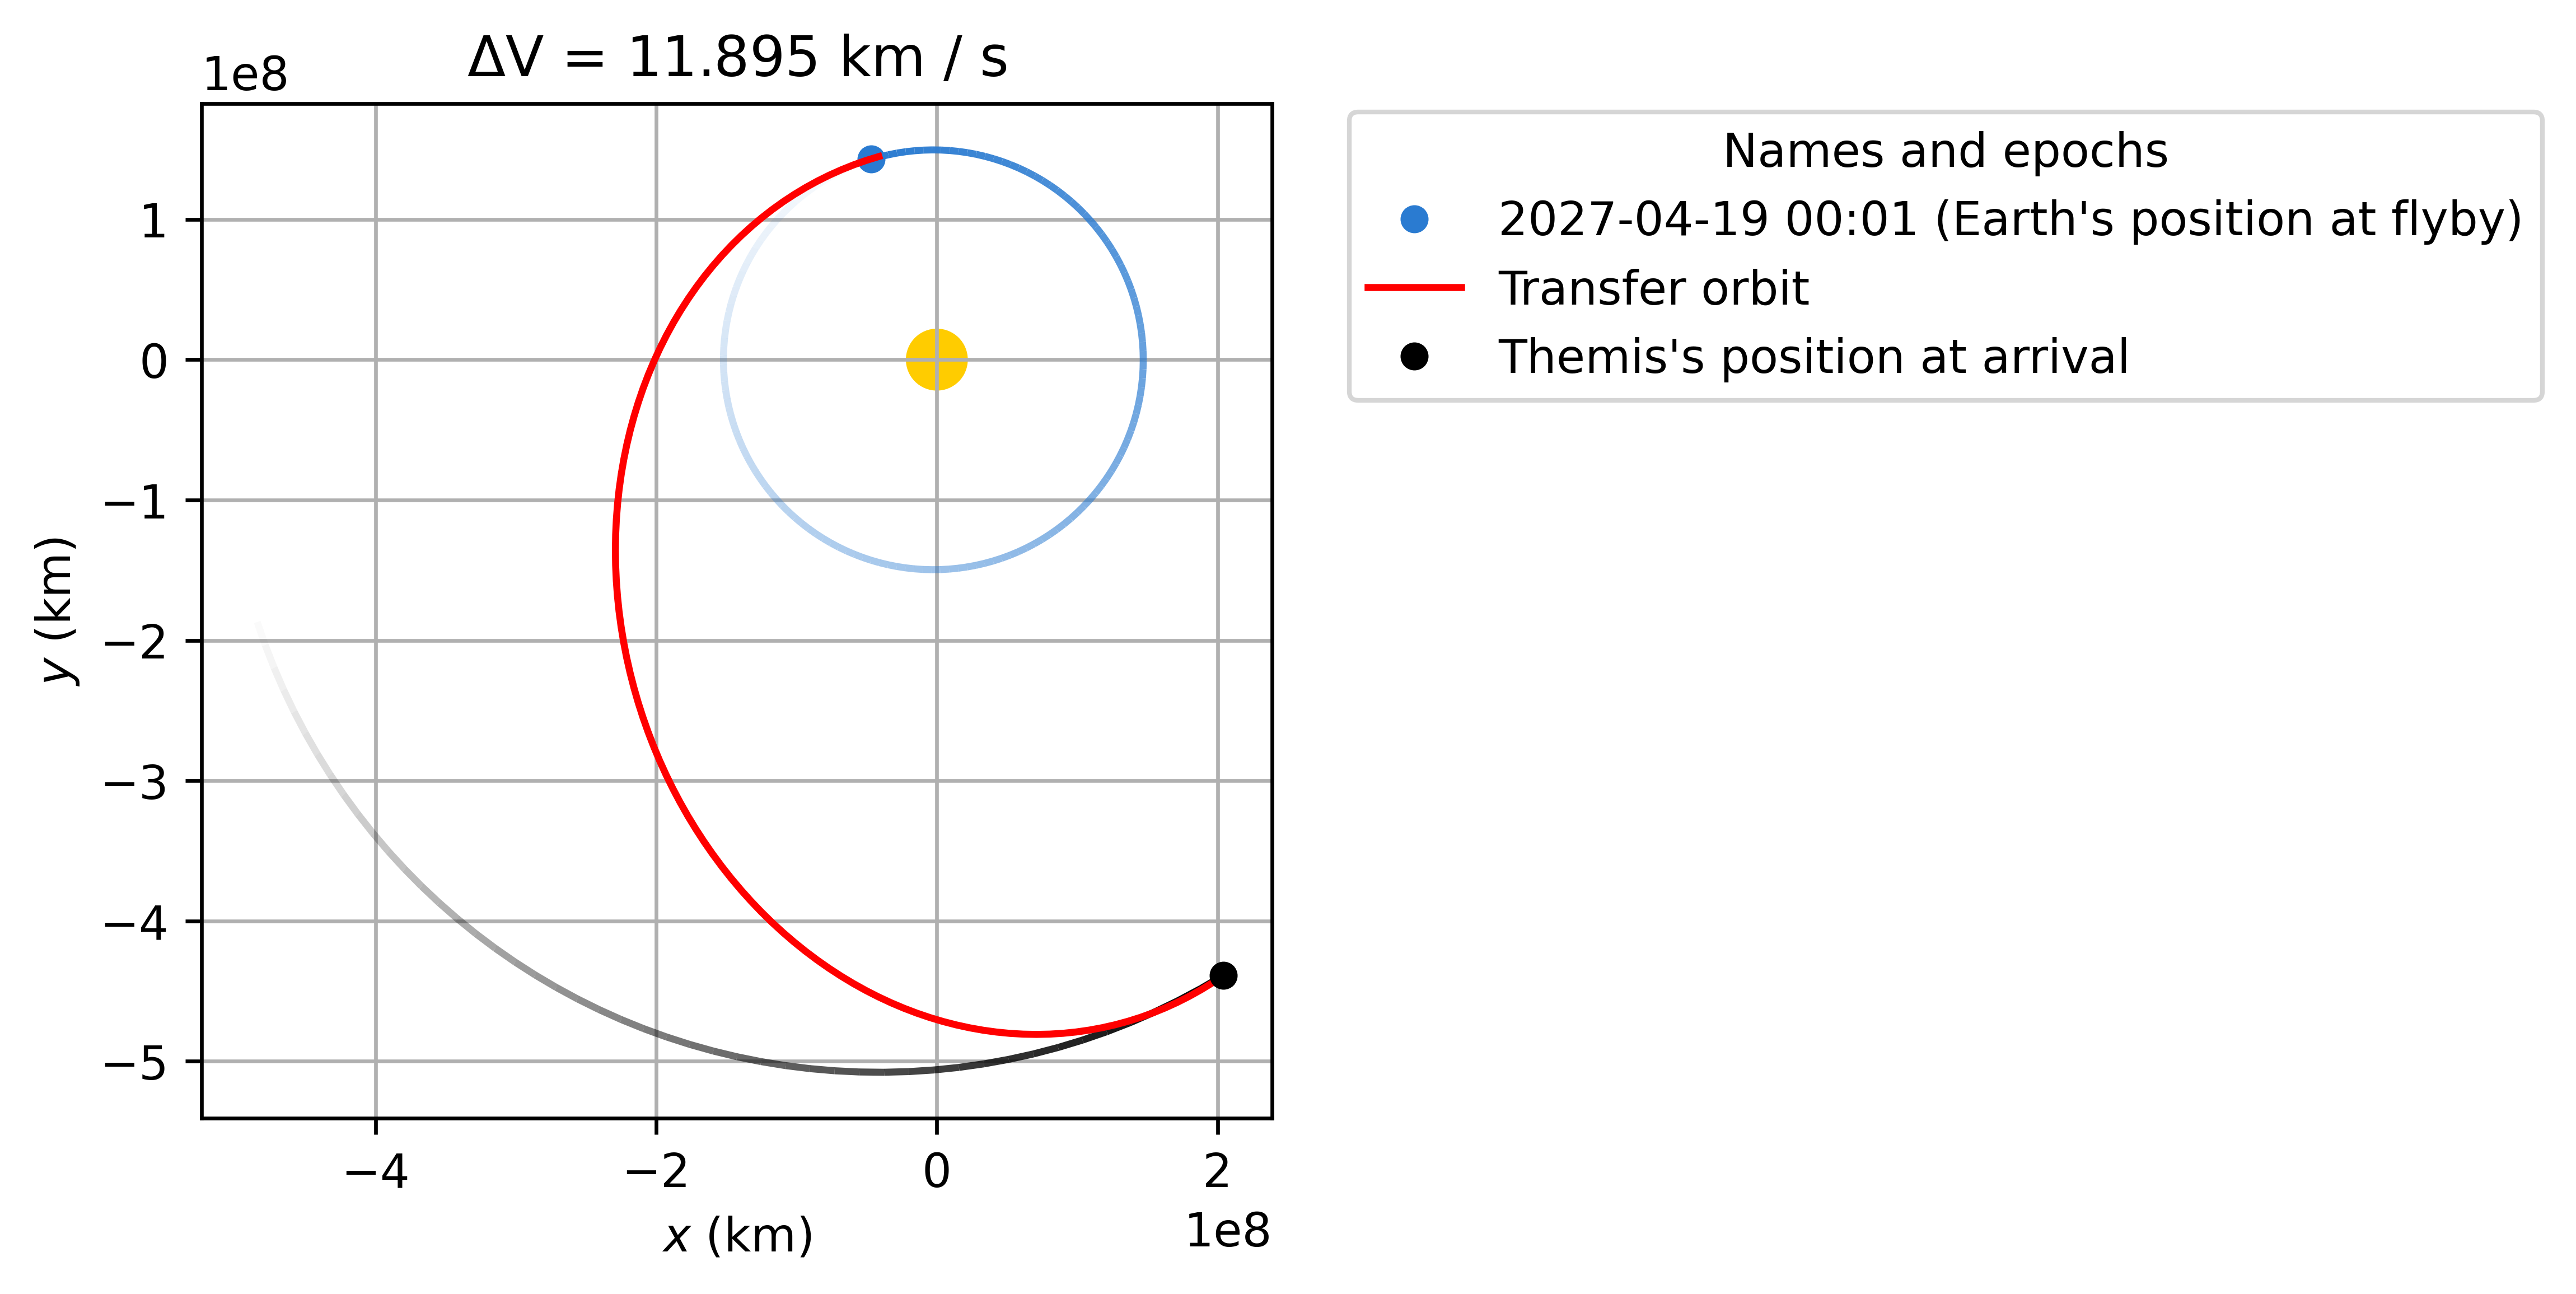

In [28]:
from astropy import units as u
from astropy import time
from astropy.time import Time, TimeDelta

import numpy as np

from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.plotting import StaticOrbitPlotter

import matplotlib.pyplot as plt

# More info: https://plotly.com/python/renderers/
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

C_FLORENCE = "#000"

# Initial data
date_launch = time.Time("2027-04-19", scale="utc").tdb
date_arrival = time.Time("2029-01-28", scale="utc").tdb


# получаем координаты тел
earth = Ephem.from_body(Earth, time_range(date_launch, end=date_arrival))
#--------------------------------------------------------------------------
#themis = Ephem.from_body(Mars, time_range(date_launch, end=date_arrival))

EPOCH = Time(date_arrival, scale="tdb")
epochs = time_range(EPOCH - TimeDelta(15 * u.day), end=EPOCH + TimeDelta(600 * u.day))

#themis = Ephem.from_horizons("Themis", epochs, plane=Planes.EARTH_ECLIPTIC)
themis = Ephem.from_horizons("Themis", time_range(date_launch, end=date_arrival), plane=Planes.EARTH_EQUATOR)

# Solve for departure and target orbits
ss_earth = Orbit.from_ephem(Sun, earth, date_launch)
ss_themis = Orbit.from_ephem(Sun, themis, date_arrival)


# Solve for the transfer maneuver
man_lambert = Maneuver.lambert(ss_earth, ss_themis)

# Get total DeltaV
totalDV = format(man_lambert.get_total_cost(), ".3f")
print(totalDV)

# Get the transfer and final orbits
ss_trans, ss_target = ss_earth.apply_maneuver(man_lambert, intermediate=True)


plt.rcParams['figure.dpi'] = 600
fig, ax = plt.subplots()

ax.grid(True)
ax.set_title(r'$\Delta$' + 'V = ' + totalDV)
ax.set_facecolor("None")

plotter = StaticOrbitPlotter(ax)

plotter.set_attractor(Sun)

plotter.plot_body_orbit(
    Earth,
    date_launch,
    label="Earth's position at flyby",
    trail=True,
)

plotter.plot_trajectory(
    ss_trans.sample(min_anomaly=0 * u.deg, max_anomaly=189 * u.deg), color="red", label="Transfer orbit"
)

plotter.plot_ephem(
    themis, date_arrival, label="Themis's position at arrival", color=C_FLORENCE, trail=True
)

